# 젠더 법안 K-means

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
from krwordrank.hangle import normalize
%matplotlib inline

In [3]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [4]:
gender = pd.read_csv('./20th-gender-bill.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자'] )
gender = gender.drop('level_0',1)
print(gender.shape)

(2016, 13)


In [5]:
gender.head()

,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자
0,2024984,처,일제하 일본군위안부 피해자에 대한 보호ㆍ지원 및 기념사업 등에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,대안의 생활안정지원대상자에게 「의료급여법」에 따른 본인 부담금 및 비급여비용에...,여성가족위원회,NaN
1,2024980,처,양육비 이행확보 및 지원에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,대안의 한시적 양육비 긴급지원이 이루어진 경우 양육비 채무자에게 국세 체납처분...,여성가족위원회,NaN
2,2024979,처,아동·청소년의 성보호에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,2. 대안의 아동？청소년 음란물 범죄의 규모와 형태가 갈수록 교묘해지고 있지만...,여성가족위원회,NaN
3,2024978,처,가족친화 사회환경의 조성 촉진에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,대안의 가족친화 사회환경 조성 기본계획이 수립된 경우 여성가족부장관은 지체 없...,여성가족위원회,NaN
4,2024977,처,가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안,위원장,2020-05-20,2020-05-20,원안가결,NaN,의안원문,제20대 (2016~2020) 제378회,대안의 배우자가 대한민국 국민이 아닌 외국인 가정폭력 피해자도 외국인보호시설의...,여성가족위원회,NaN


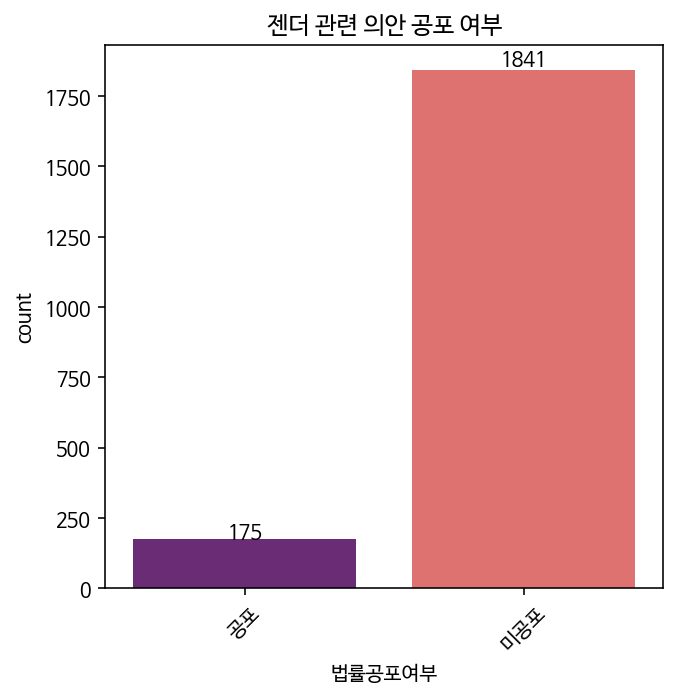

In [6]:
def proornot_vis(df, name): 
    plt.figure(figsize = (5,5))
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = '법률공포여부', data = df, 
              palette = 'magma')

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')

    plt.title(f'{name} 관련 의안 공포 여부')
    plt.show()

proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

gender.loc[gender['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
gender.loc[gender['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

proornot_vis(gender, '젠더')

In [10]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [11]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [12]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 117 ms, sys: 3.61 ms, total: 120 ms
Wall time: 122 ms


In [13]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [14]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 1min 17s, sys: 1.04 s, total: 1min 18s
Wall time: 1min 6s


0    [일제하, 일본군위안부, 피해자, 보호, 지원, 기념사업, 법률, 일부개정법률안, ...
1    [양육비, 이행확보, 지원, 법률, 일부개정법률안, 대안, 한시적, 양육비, 긴급지...
2    [아동, 청소년, 성보호, 법률, 일부개정법률안, 대안, 아동, 청소년, 음란물, ...
Name: tokens, dtype: object

In [15]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 421 ms, sys: 8.84 ms, total: 430 ms
Wall time: 494 ms


In [16]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.81 ms, sys: 1.12 ms, total: 2.94 ms
Wall time: 3.29 ms


In [27]:
# 명사 수가 50개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(2011, 17)


In [28]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [29]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-26 23:30:02,969 : INFO : collecting all words and their counts
2020-09-26 23:30:02,971 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-26 23:30:03,010 : INFO : collected 13164 word types from a corpus of 164877 raw words and 2011 sentences
2020-09-26 23:30:03,010 : INFO : Loading a fresh vocabulary
2020-09-26 23:30:03,024 : INFO : effective_min_count=10 retains 2106 unique words (15% of original 13164, drops 11058)
2020-09-26 23:30:03,032 : INFO : effective_min_count=10 leaves 139227 word corpus (84% of original 164877, drops 25650)
2020-09-26 23:30:03,049 : INFO : deleting the raw counts dictionary of 13164 items
2020-09-26 23:30:03,059 : INFO : sample=0.001 downsamples 69 most-common words
2020-09-26 23:30:03,061 : INFO : downsampling leaves estimated 121161 word corpus (87.0% of prior 139227)
2020-09-26 23:30:03,072 : INFO : estimated required memory for 2106 words and 100 dimensions: 2737800 bytes
2020-09-26 23:30:03,083 : INFO : resetting

2020-09-26 23:30:05,400 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:05,402 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:05,408 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:05,408 : INFO : EPOCH - 15 : training on 164877 raw words (121181 effective words) took 0.1s, 1062650 effective words/s
2020-09-26 23:30:05,514 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:05,519 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:05,523 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:05,524 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:05,525 : INFO : EPOCH - 16 : training on 164877 raw words (121030 effective words) took 0.1s, 1065458 effective words/s
2020-09-26 23:30:05,637 : INFO : worker thread finished; awaiting finish of 3 more thread

2020-09-26 23:30:07,235 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:07,237 : INFO : EPOCH - 31 : training on 164877 raw words (121329 effective words) took 0.1s, 960471 effective words/s
2020-09-26 23:30:07,352 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:07,356 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:07,358 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:07,361 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:07,362 : INFO : EPOCH - 32 : training on 164877 raw words (121218 effective words) took 0.1s, 1004319 effective words/s
2020-09-26 23:30:07,459 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:07,461 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:07,466 : INFO : worker thread finished; awaiting finish of 1 more threads

2020-09-26 23:30:09,064 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:09,071 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:09,073 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:09,075 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:09,076 : INFO : EPOCH - 48 : training on 164877 raw words (121273 effective words) took 0.1s, 1201685 effective words/s
2020-09-26 23:30:09,169 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:09,175 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:09,178 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:09,182 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:09,184 : INFO : EPOCH - 49 : training on 164877 raw words (121323 effective words) took 0.1s, 1189037 effective words/

2020-09-26 23:30:10,864 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:10,867 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:10,869 : INFO : EPOCH - 64 : training on 164877 raw words (121261 effective words) took 0.1s, 1151134 effective words/s
2020-09-26 23:30:10,962 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:10,968 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:10,969 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:10,971 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:10,971 : INFO : EPOCH - 65 : training on 164877 raw words (121130 effective words) took 0.1s, 1223930 effective words/s
2020-09-26 23:30:11,072 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:11,076 : INFO : worker thread finished; awaiting finish of 2 more thread

2020-09-26 23:30:12,683 : INFO : EPOCH - 80 : training on 164877 raw words (121108 effective words) took 0.1s, 1044285 effective words/s
2020-09-26 23:30:12,775 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:12,785 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:12,786 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:12,790 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:12,791 : INFO : EPOCH - 81 : training on 164877 raw words (121087 effective words) took 0.1s, 1208047 effective words/s
2020-09-26 23:30:12,883 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:12,888 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:12,891 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:12,893 : INFO : worker thread finished; awaiting finish of 0 more thread

2020-09-26 23:30:14,517 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:14,519 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:14,523 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:14,524 : INFO : EPOCH - 97 : training on 164877 raw words (121273 effective words) took 0.1s, 1099145 effective words/s
2020-09-26 23:30:14,618 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:30:14,620 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:30:14,626 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:30:14,629 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:30:14,629 : INFO : EPOCH - 98 : training on 164877 raw words (121299 effective words) took 0.1s, 1190707 effective words/s
2020-09-26 23:30:14,719 : INFO : worker thread finished; awaiting finish of 3 more thread

In [30]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [31]:
# 문장 벡터 생성
gender['문장벡터'] = gender['tokens'].map(get_sentence_mean_vector)

In [32]:
len(gender['문장벡터'][0])

100

In [79]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

[('인사상', 0.4144613742828369), ('비중', 0.3782542943954468), ('승진', 0.36777782440185547), ('유리천장', 0.35802769660949707), ('비율', 0.35765430331230164), ('처우', 0.3527390956878662), ('격차', 0.35049712657928467), ('공공기관', 0.35026469826698303), ('전보', 0.3455127477645874), ('임금격차', 0.3405422568321228)]
[('아동', 0.5634642839431763), ('청소년대상', 0.43761831521987915), ('청소년들', 0.3801547586917877), ('취업제한', 0.3779989182949066), ('착취', 0.3733591139316559), ('음란', 0.3394482731819153), ('신뢰관계', 0.33675438165664673), ('청소년성착취물', 0.332133412361145), ('성범죄', 0.3183179795742035), ('음란물', 0.31564128398895264)]


In [19]:
# model.wv.vocab.items()

## t-SNE 시각화

In [34]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(gender['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=gender['의안명'], columns=["x", "y"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2011 samples in 0.011s...
[t-SNE] Computed neighbors for 2011 samples in 0.738s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2011
[t-SNE] Computed conditional probabilities for sample 2000 / 2011
[t-SNE] Computed conditional probabilities for sample 2011 / 2011
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.965508
[t-SNE] KL divergence after 300 iterations: 1.291837


In [35]:
tsne_df.head()

,x,y
의안명,,
일제하 일본군위안부 피해자에 대한 보호ㆍ지원 및 기념사업 등에 관한 법률 일부개정법률안,1.638200,3.523131
양육비 이행확보 및 지원에 관한 법률 일부개정법률안,9.547614,13.550651
아동·청소년의 성보호에 관한 법률 일부개정법률안,-14.725924,-1.080294
가족친화 사회환경의 조성 촉진에 관한 법률 일부개정법률안,4.460075,-4.262521
가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안,-2.583614,11.346319


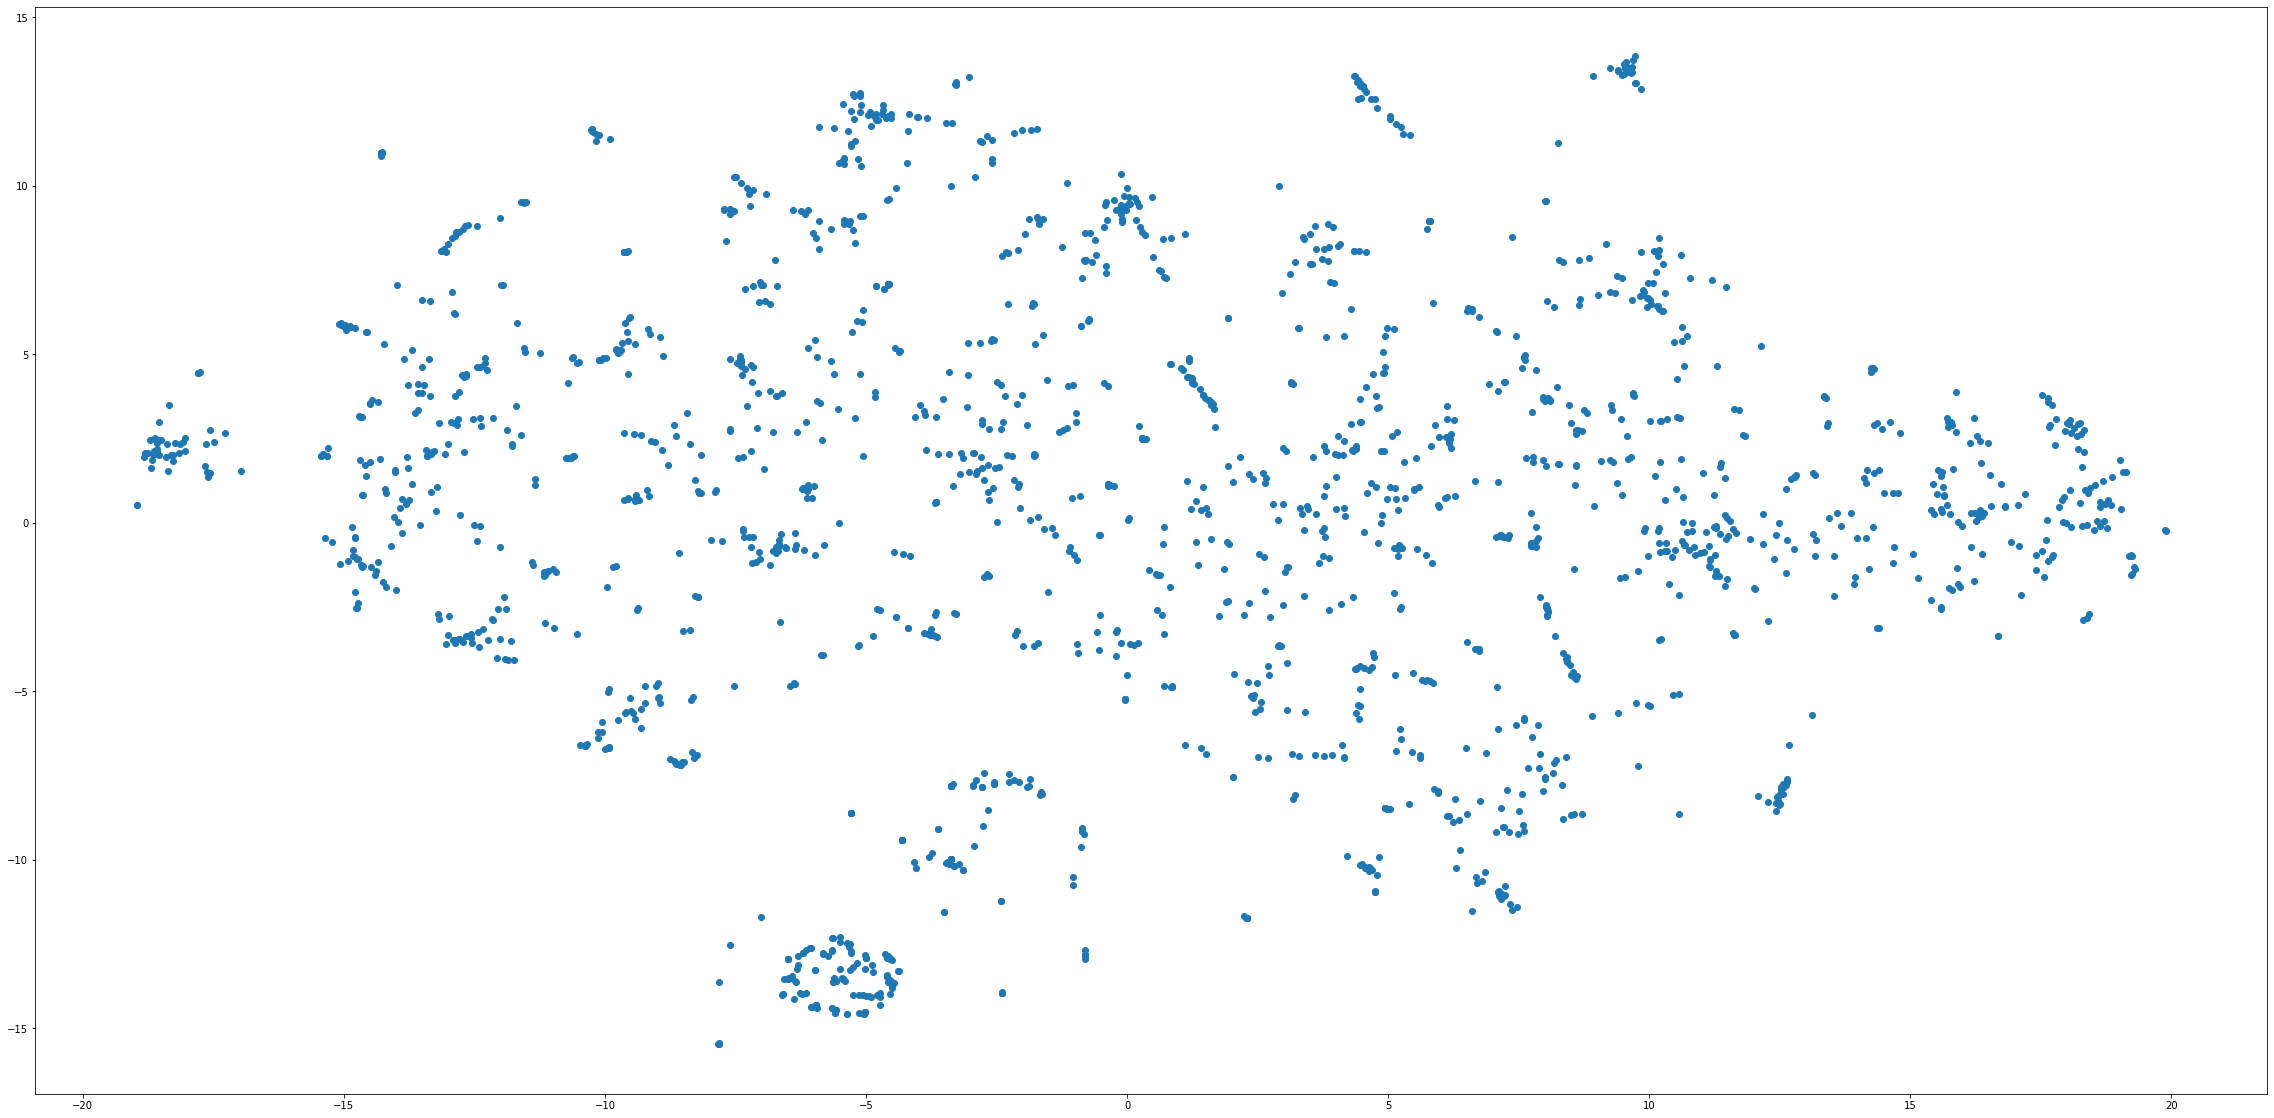

In [36]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

#for word, pos in list(df.iterrows()):
#    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

## 군집개수 결정 - 엘보우 함수

엘보우: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]


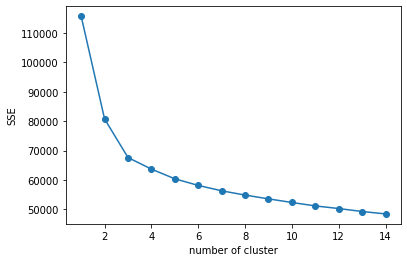

In [37]:
# 엘보우 함수로 군집 개수 결정

word_vectors = gender['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

## 군집개수 결정 - 실루엣 계수

In [38]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

## KMeans

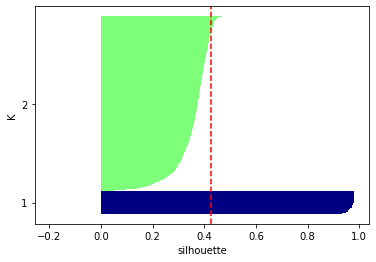

In [39]:
word_vectors = gender['문장벡터'].to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

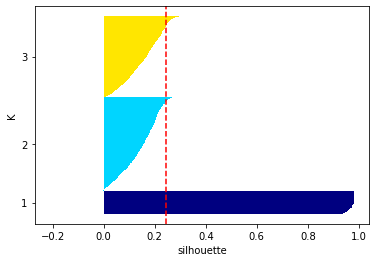

In [40]:
word_vectors = gender['문장벡터'].to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

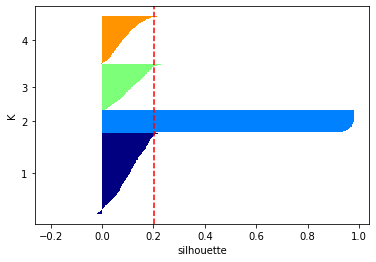

In [41]:
word_vectors = gender['문장벡터'].to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

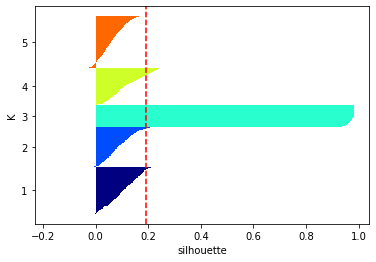

In [42]:
word_vectors = gender['문장벡터'].to_list()
k= 5

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

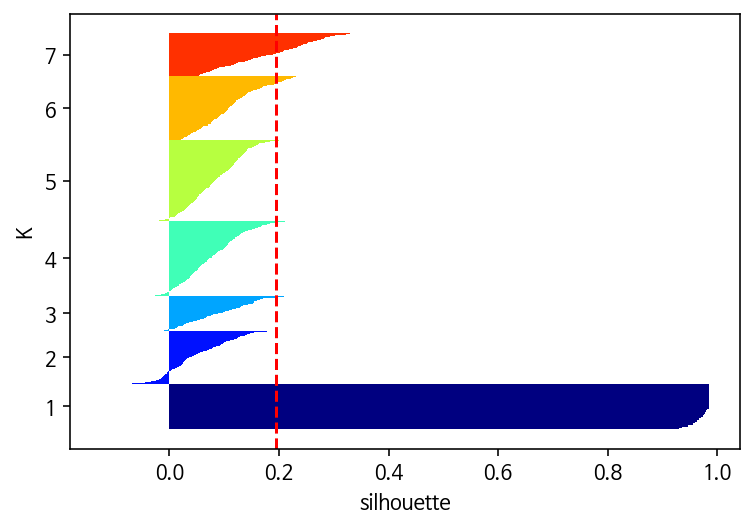

In [61]:
word_vectors = gender['문장벡터'].to_list()
k= 7

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## KMeans 수행

In [85]:
# K means 수행 
word_vectors = gender['문장벡터'].to_list()
num_clusters = 6

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
gender['category'] = idx

In [86]:
gender['category'].value_counts()

1    476
5    406
3    406
0    276
2    227
4    220
Name: category, dtype: int64

In [87]:
from sklearn.manifold import TSNE

X = gender['문장벡터'].to_list()
y = gender['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

'''
# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)
'''

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = gender['의안번호'].to_list()
tsne_df['BillName'] = gender['의안명'].to_list()
tsne_df['cluster_no'] = y

In [88]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [89]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]
colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}
colors = [colormap[x] for x in tsne_df['cluster_no']]
tsne_df['color'] = colors

In [90]:
# Bokeh가 인식하는 DataSource 객체 만들어주기
plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)
tsne_plot = figure(
    title='Bills about gender',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [91]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)


## 군집별 핵심단어 추출

In [92]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-09-26 23:41:25,248 : INFO : Generating new fontManager, this may take some time...
2020-09-26 23:41:25,863 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-26 23:41:25,927 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-26 23:41:26,169 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str


In [93]:
gender_g1 = gender[gender['category'] == 0]
gender_g2 = gender[gender['category'] == 1]
gender_g3 = gender[gender['category'] == 2]
gender_g4 = gender[gender['category'] == 3]
gender_g5 = gender[gender['category'] == 4]
gender_g6 = gender[gender['category'] == 5]
# gender_g7 = gender[gender['category'] == 6]

In [94]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
            
gender_g1_tokens = total_tokens(gender_g1['tokens'])
gender_g2_tokens = total_tokens(gender_g2['tokens'])
gender_g3_tokens = total_tokens(gender_g3['tokens'])
gender_g4_tokens = total_tokens(gender_g4['tokens'])
gender_g5_tokens = total_tokens(gender_g5['tokens'])
gender_g6_tokens = total_tokens(gender_g6['tokens'])
# gender_g7_tokens = total_tokens(gender_g7['tokens'])

In [95]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고']
gender_g1_tokens = [each_word for each_word in gender_g1_tokens if each_word not in stopwords]
gender_g2_tokens = [each_word for each_word in gender_g2_tokens if each_word not in stopwords]
gender_g3_tokens = [each_word for each_word in gender_g3_tokens if each_word not in stopwords]
gender_g4_tokens = [each_word for each_word in gender_g4_tokens if each_word not in stopwords]
gender_g5_tokens = [each_word for each_word in gender_g5_tokens if each_word not in stopwords]
gender_g6_tokens = [each_word for each_word in gender_g6_tokens if each_word not in stopwords]
# gender_g7_tokens = [each_word for each_word in gender_g7_tokens if each_word not in stopwords]

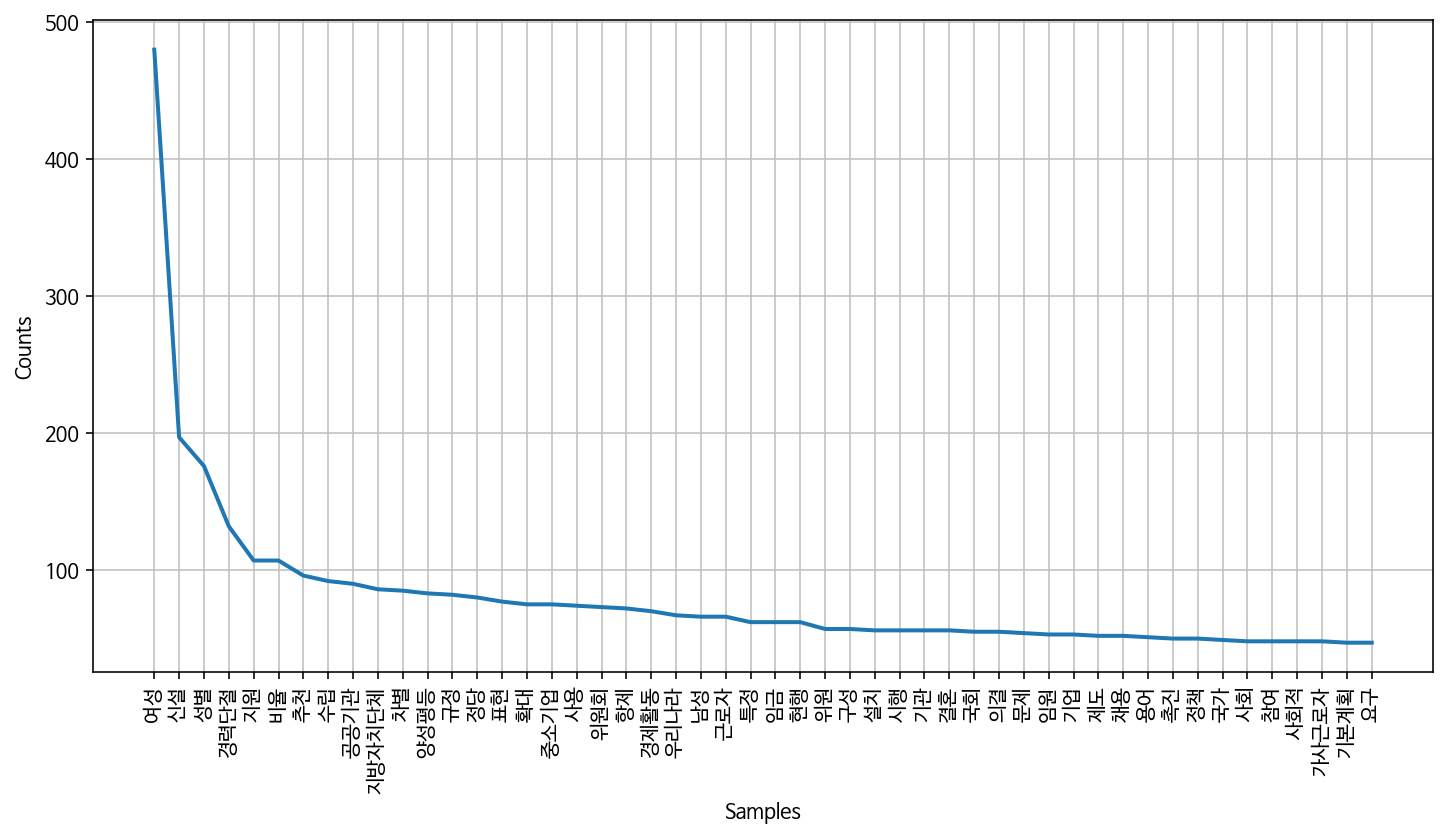

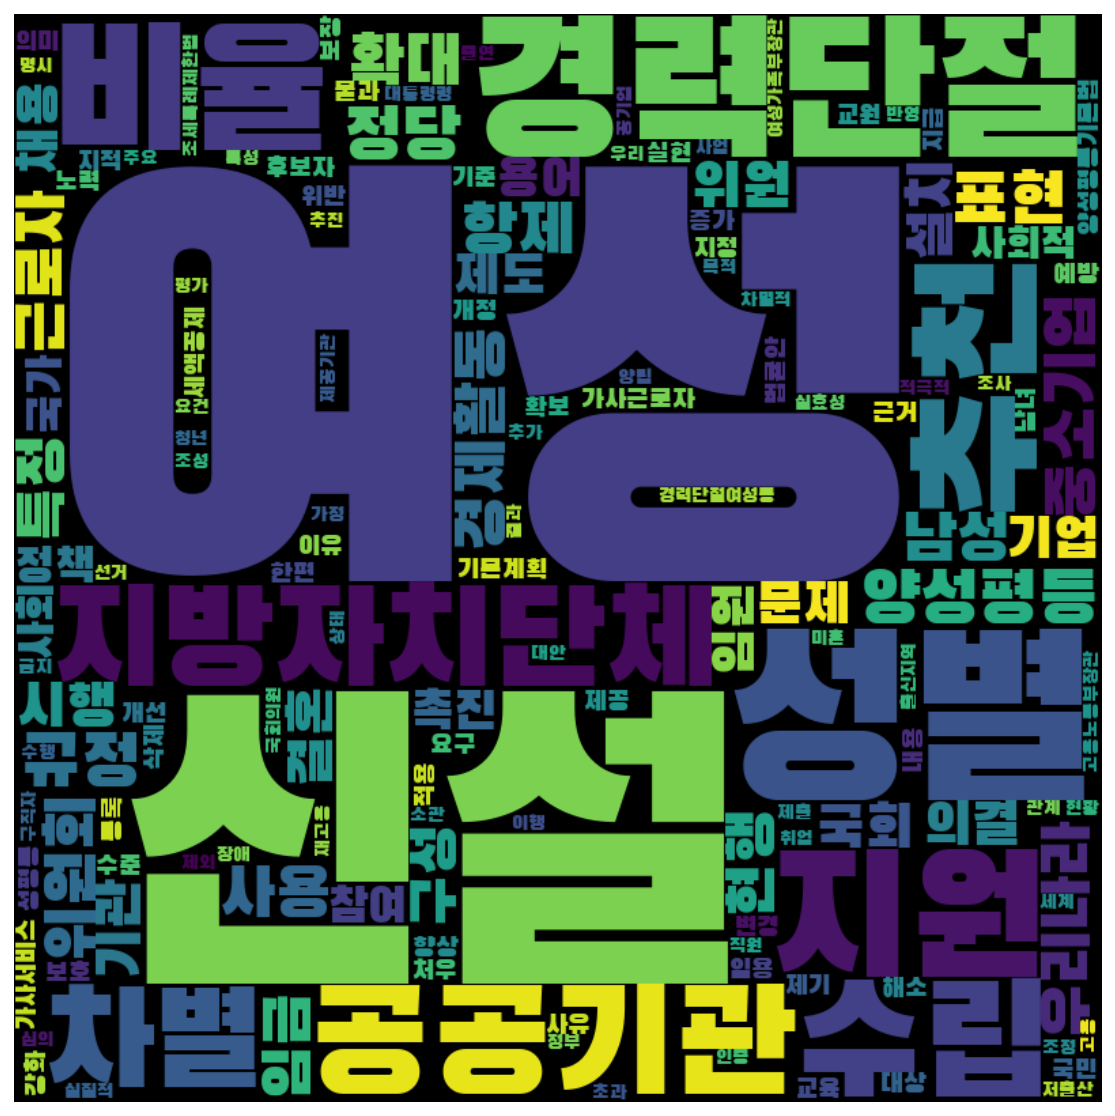

In [96]:
frewords_vis(gender_g1_tokens)
wordcloud_vis(gender_g1_tokens)

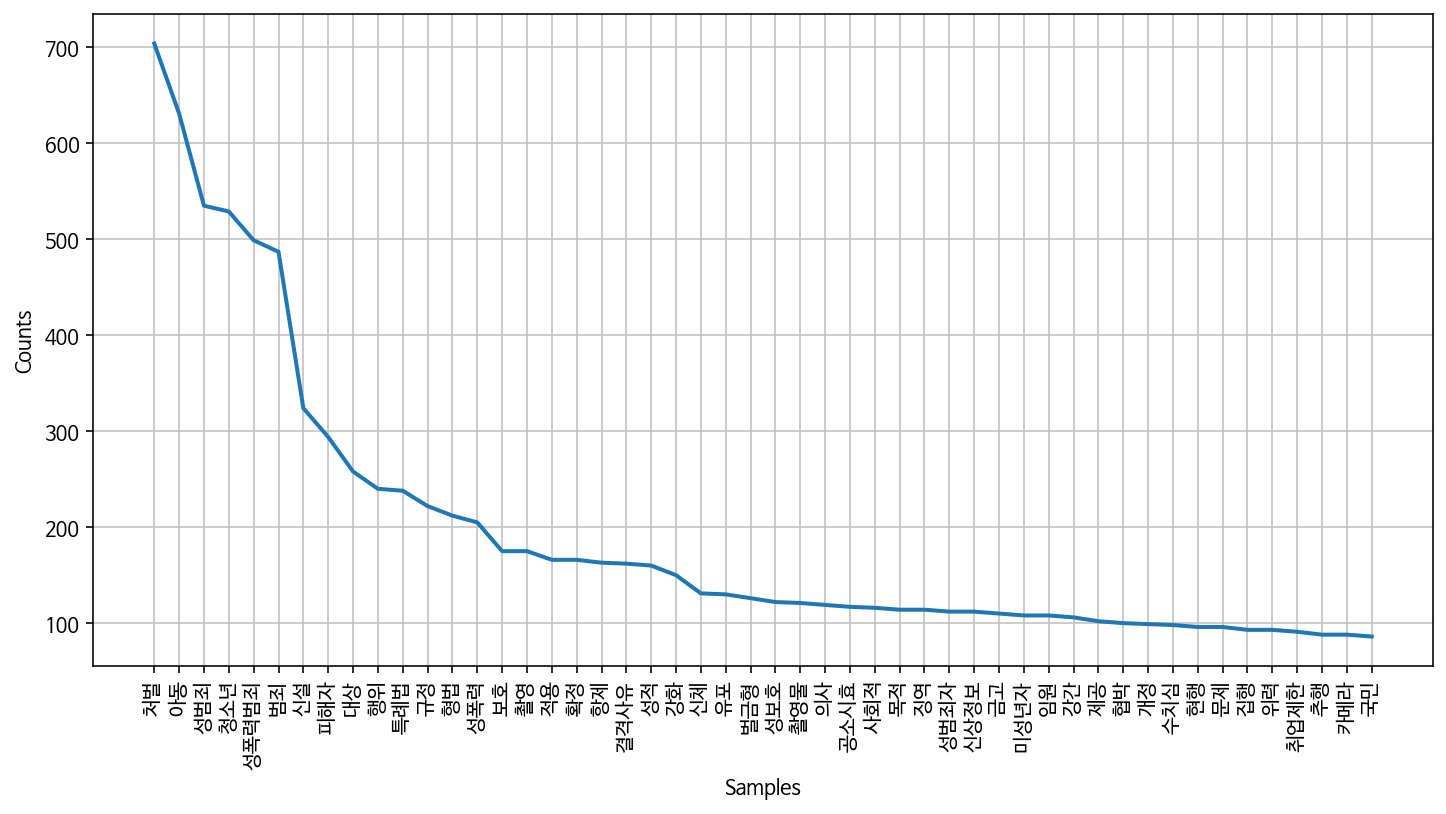

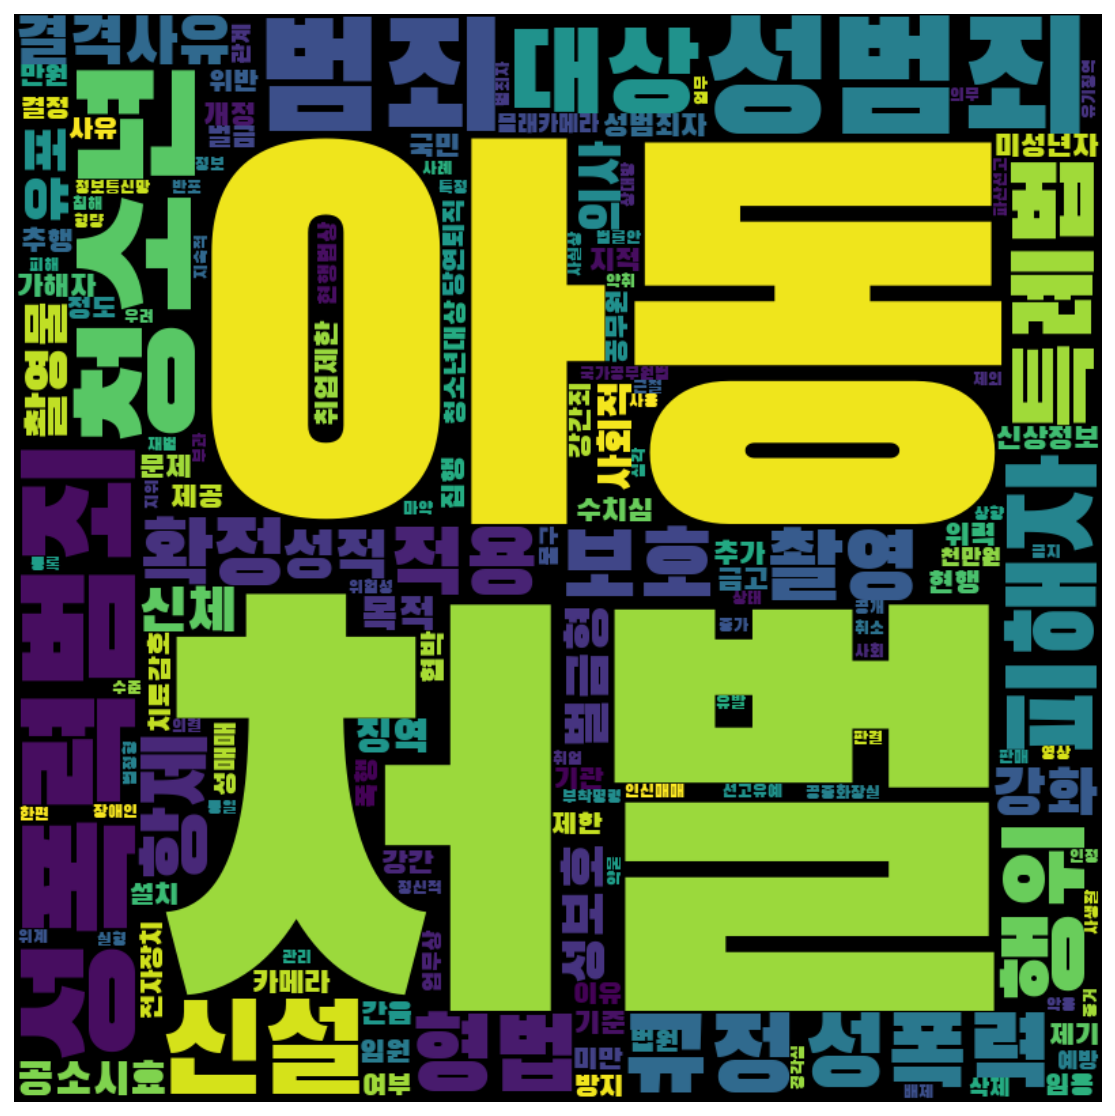

In [97]:
frewords_vis(gender_g2_tokens)
wordcloud_vis(gender_g2_tokens)

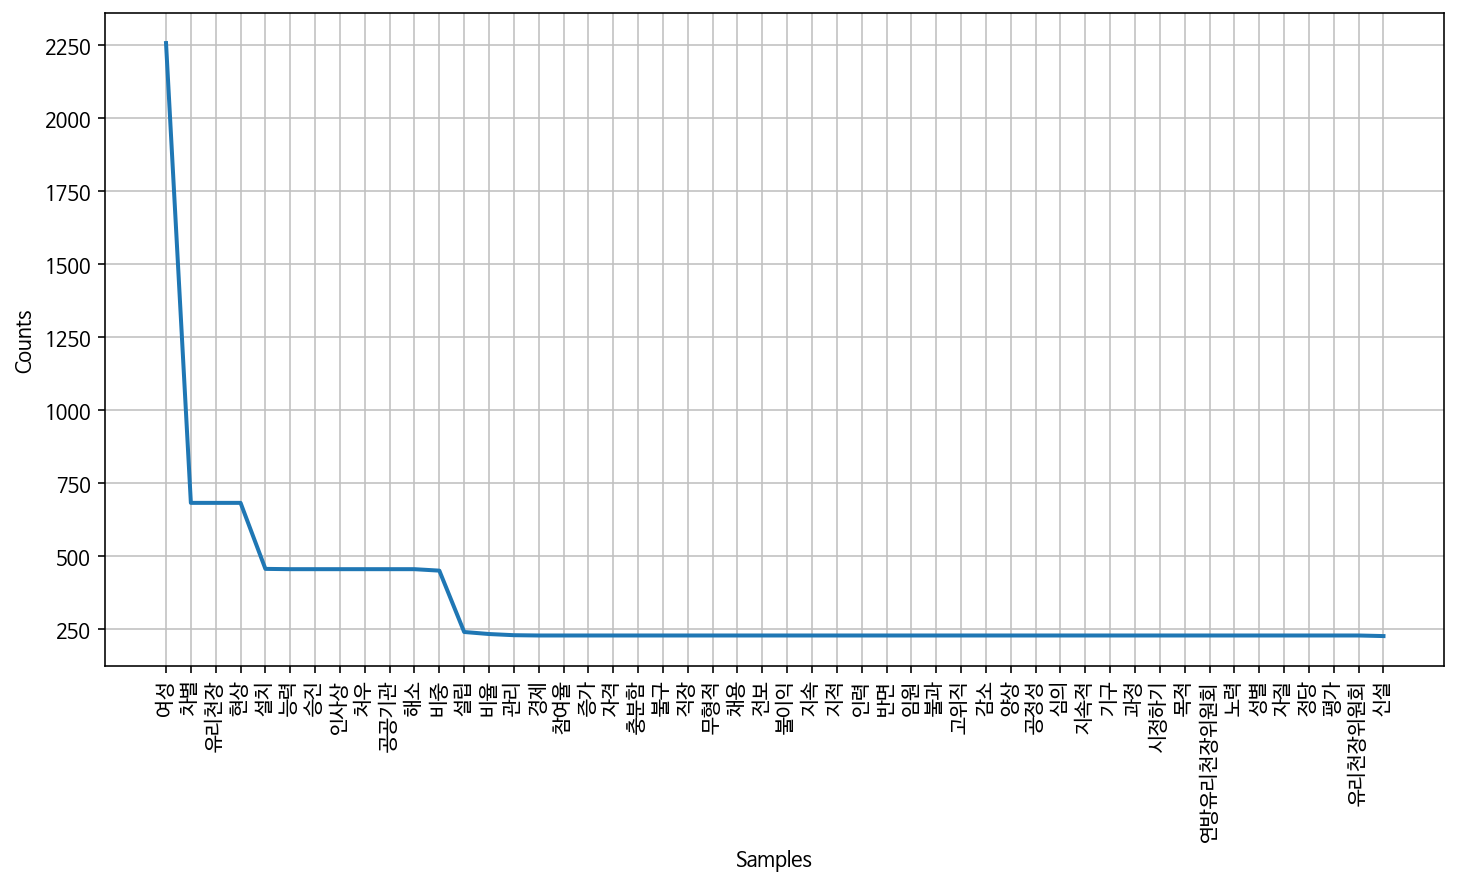

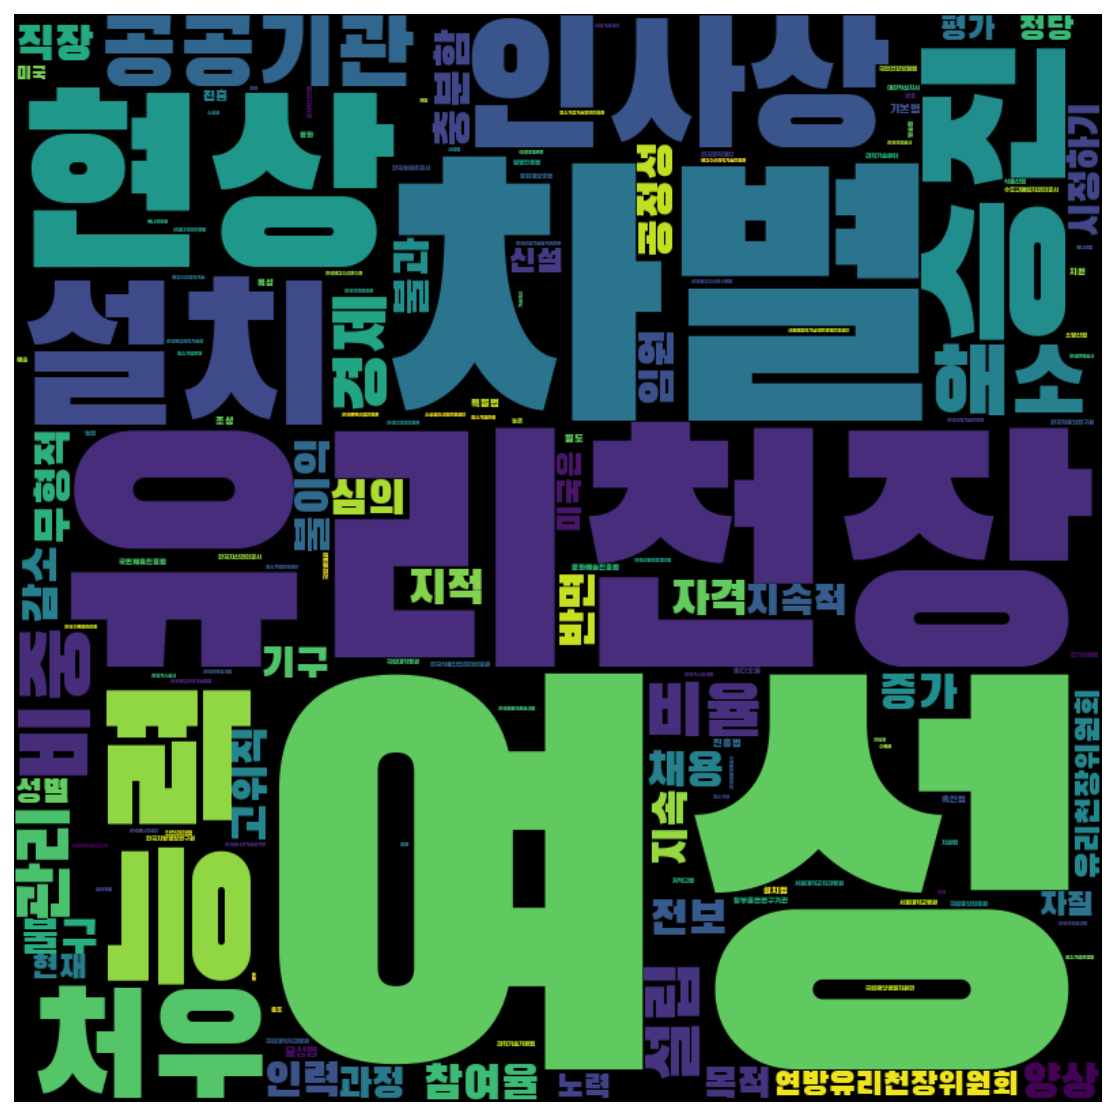

In [98]:
frewords_vis(gender_g3_tokens)
wordcloud_vis(gender_g3_tokens)

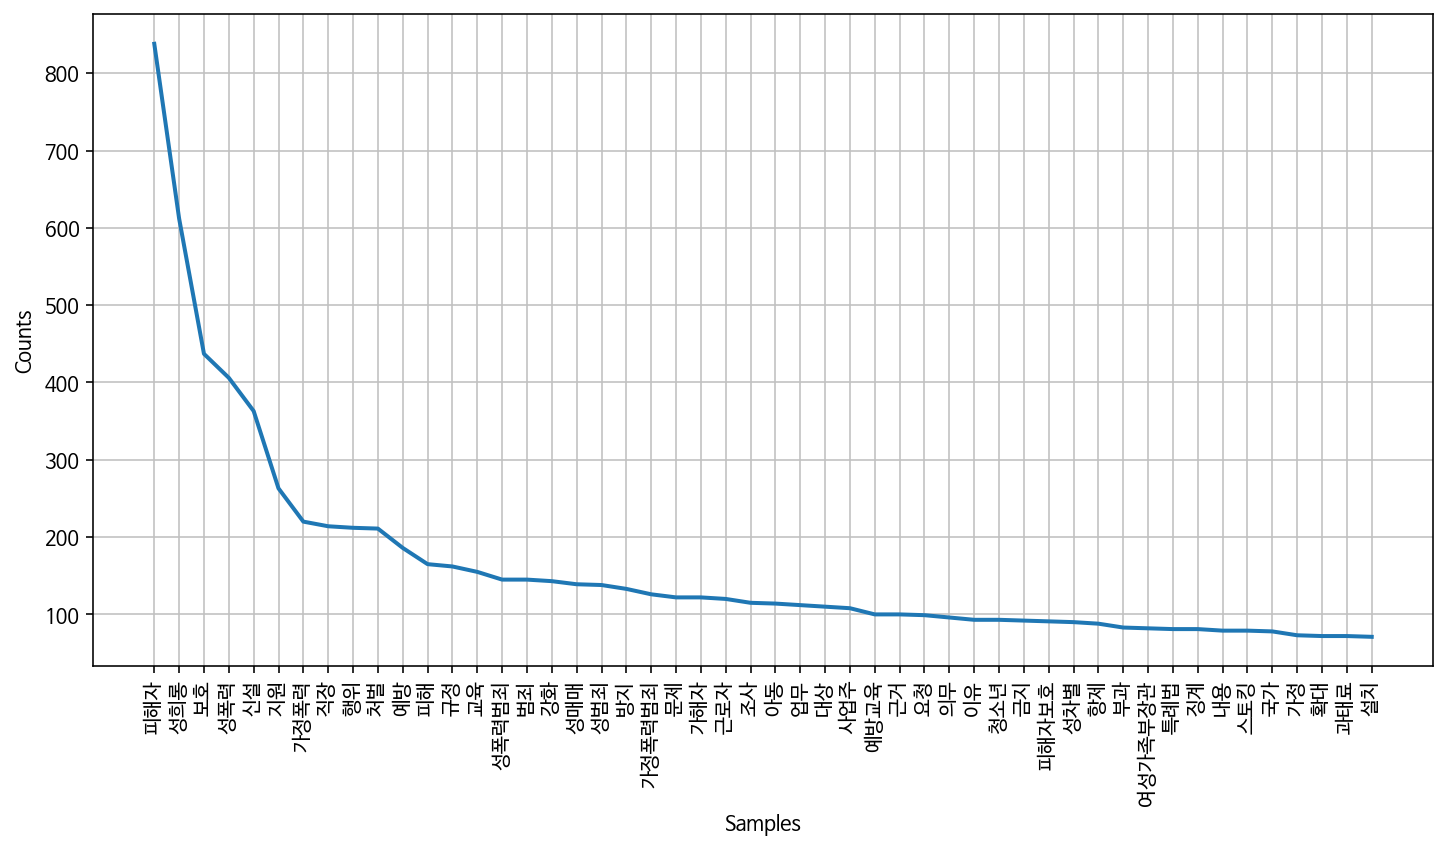

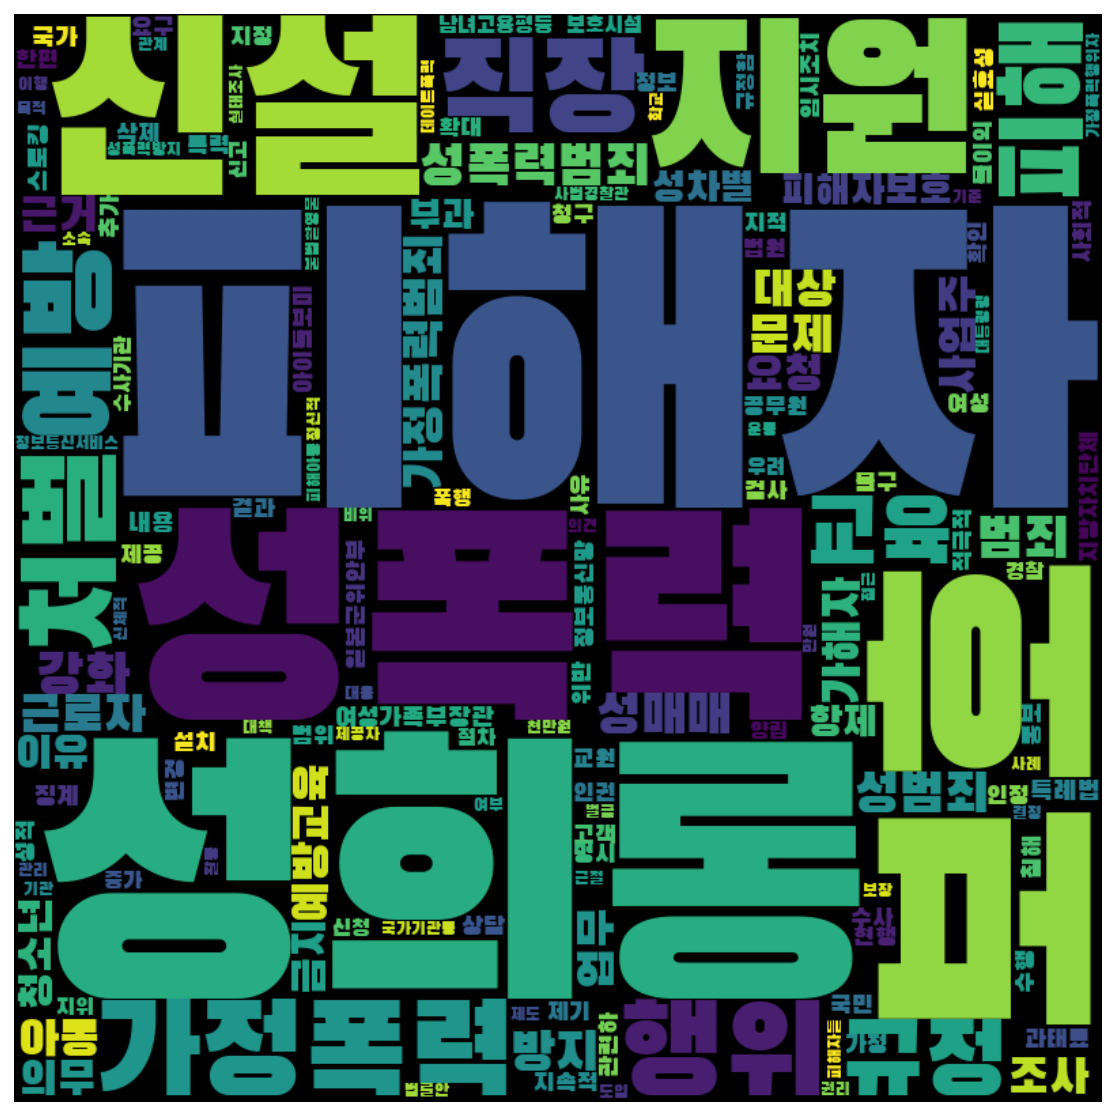

In [99]:
frewords_vis(gender_g4_tokens)
wordcloud_vis(gender_g4_tokens)

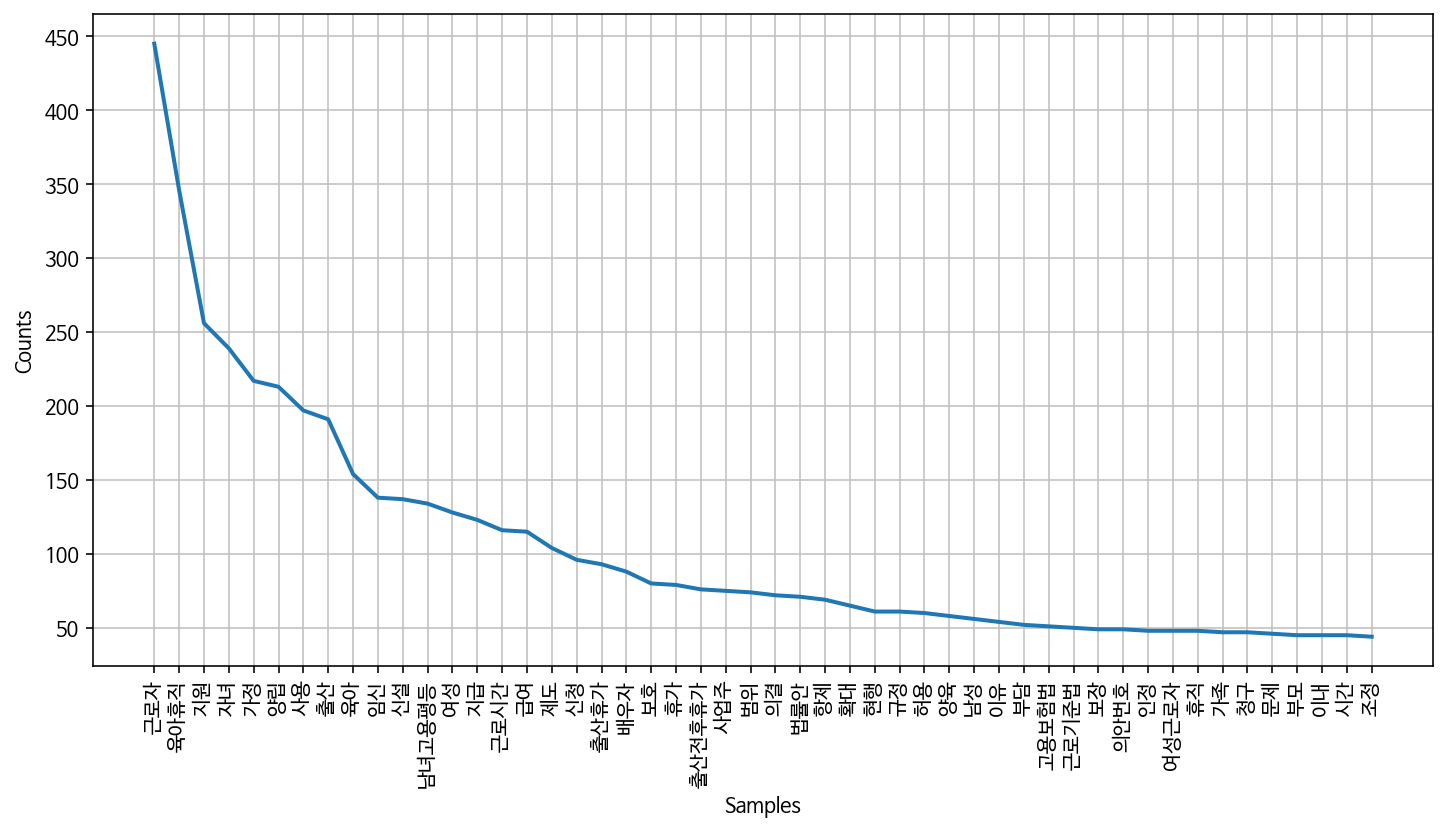

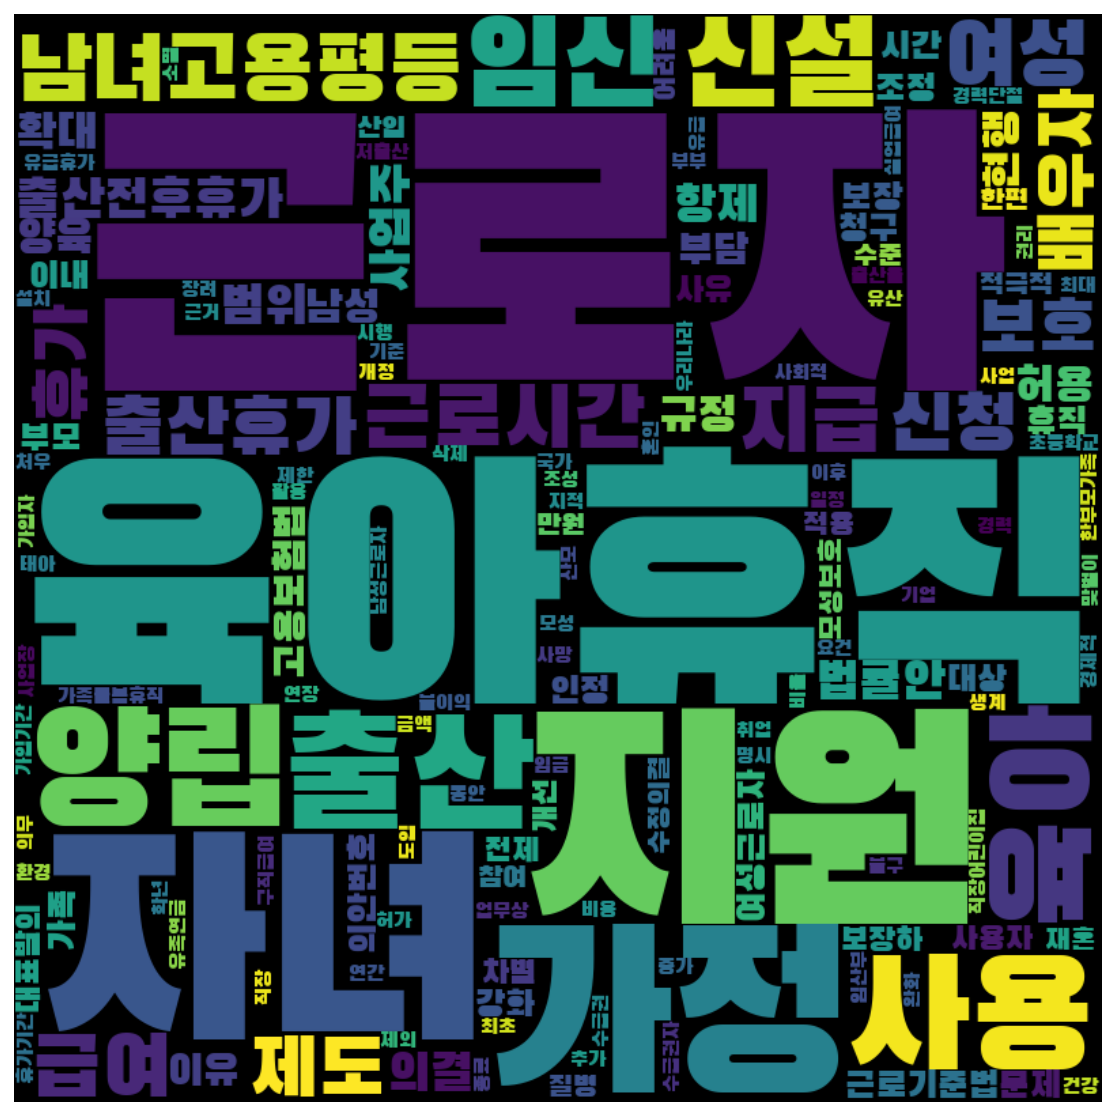

In [100]:
frewords_vis(gender_g5_tokens)
wordcloud_vis(gender_g5_tokens)

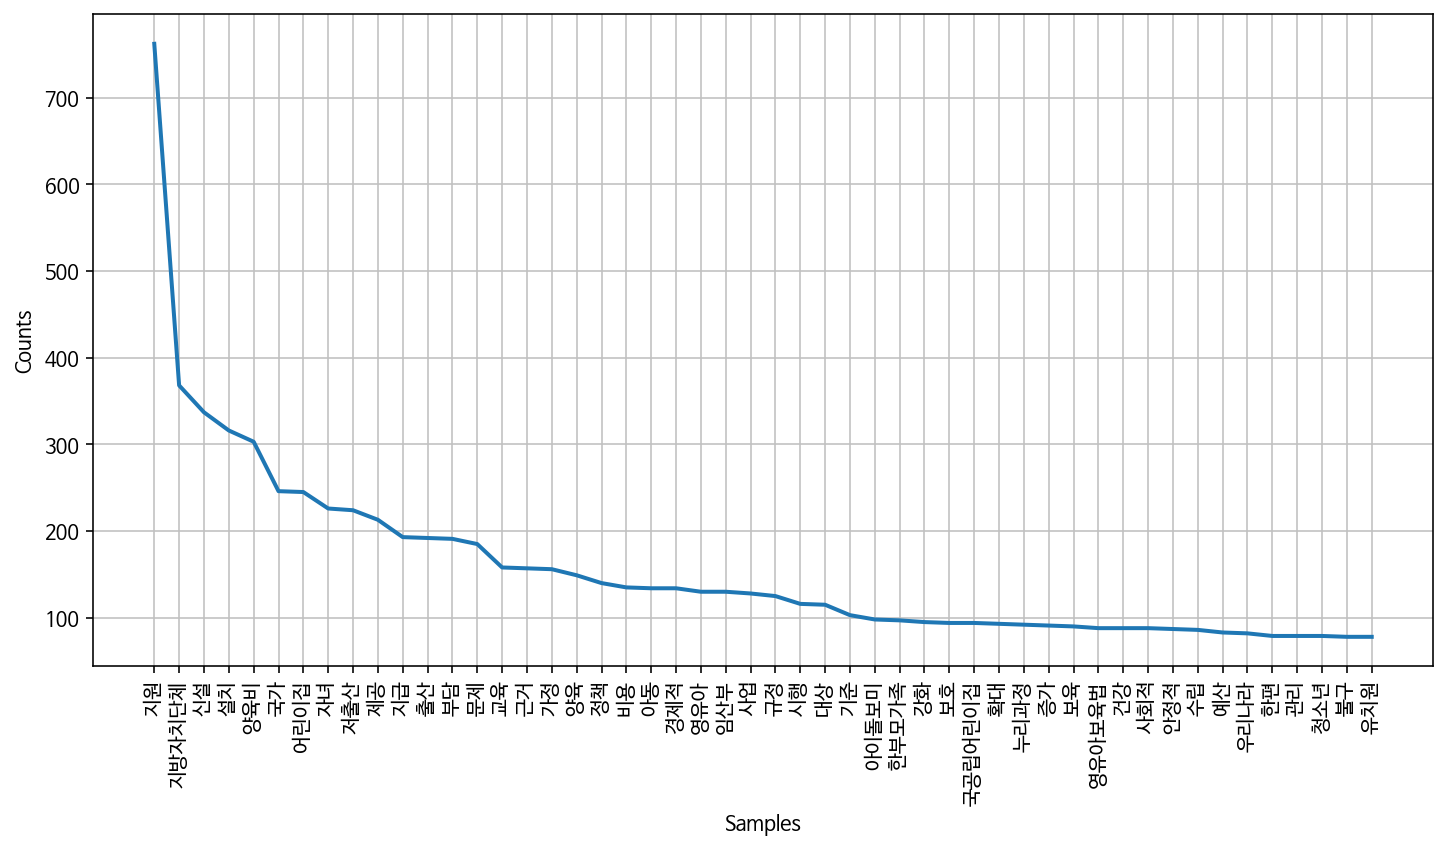

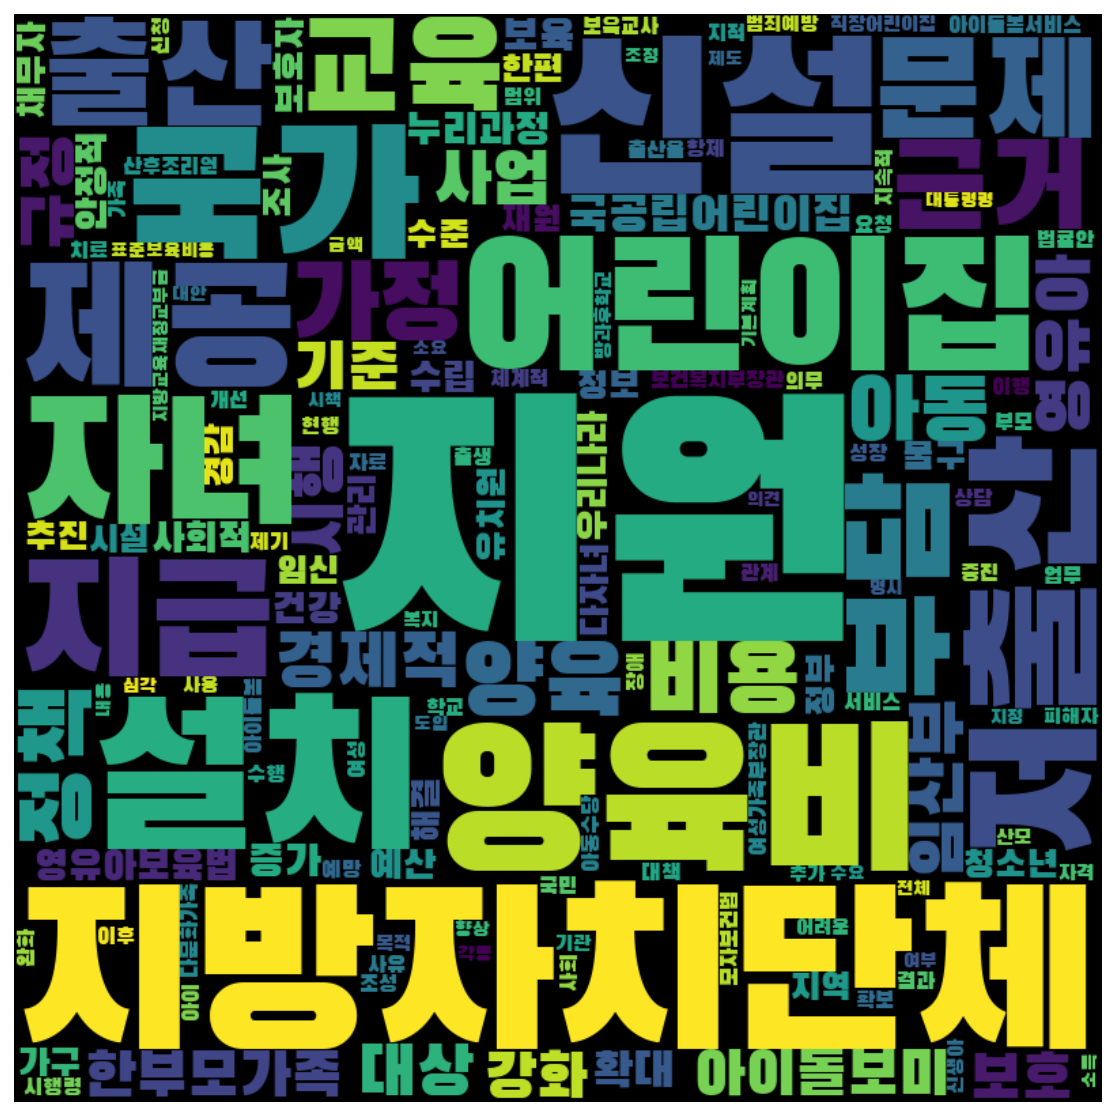

In [101]:
frewords_vis(gender_g6_tokens)
wordcloud_vis(gender_g6_tokens)

In [102]:
#frewords_vis(gender_g7_tokens)
# wordcloud_vis(gender_g7_tokens)